<a href="https://colab.research.google.com/github/mlerma54/RSIGradCAM/blob/main/RSI_Grad_CAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **RSI-Grad-CAM (Rieman-Stieltjes Integrated Grad-CAM)**

# Version of the code for public posting

In [1]:
# code version
ver='2021-03-29a'
print('code version:',ver)

code version: 2021-03-29a


In [2]:
# mount drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
# ADJUST ROOT IF NEEDED
root = '/content/gdrive/My Drive/RSI-Grad-CAM/'

In [4]:
# Make sure that we use tensorflow 2
%tensorflow_version 2.x
import tensorflow
print('TensorFlow version:', tensorflow.__version__)

TensorFlow version: 2.4.1


# **Load packages**

In [5]:
# import the necessary packages
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
from tensorflow.keras.applications import VGG19
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications import imagenet_utils
import numpy as np
import imutils
import cv2

from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt

# **RSI-Grad-CAM**

Support material.

- [Grad-CAM tutorial](https://www.pyimagesearch.com/2020/03/09/grad-cam-visualize-class-activation-maps-with-keras-tensorflow-and-deep-learning/) by Adrian Rosebrock

- [Integrated Gradients tutorial](https://www.tensorflow.org/tutorials/interpretability/integrated_gradients) from TensorFlow 

- [Wiki article on Rienmann-Stieltjes Integral](https://en.wikipedia.org/wiki/Riemann%E2%80%93Stieltjes_integral)

In [6]:
# RSI-GradCAM Class

class RSI_GradCAM:

  def __init__(self, model, classIdx, layerName=None, baseline=None, m_steps=None, batch_size=None, add_softmax=None):
    # store the model, the class index used to measure the class
    # activation map, and the layer to be used when visualizing
    # the class activation map
    self.model = model
    self.classIdx = classIdx
    self.layerName = layerName

    # if the layer name is None, attempt to automatically find
    # the target output layer
    if self.layerName is None:
      self.layerName = self.find_target_layer()

    # additional parameters inspired on integrated gradients
    self.baseline = baseline # baseline image, it could be a completely black image
    self.m_steps = m_steps # number of interpolation steps
    self.batch_size = batch_size # number of gradients to compute for each pass of the integrated gradients loop
    self.add_softmax = add_softmax # set True if the model lacks a final softmax    

    # defaults
    if self.classIdx is None:
      self.classIdx = 0
    if self.m_steps is None:
      self.m_steps = 256
    if batch_size is None:
      self.batch_size = 32
    if self.add_softmax is None:
      self.add_softmax = False

    # construct our gradient model by supplying (1) the inputs
    # to our pre-trained model, (2) the output of the (presumably)
    # final 4D layer in the network, and (3) the output of the
    # softmax activations from the model
    self.gradModel = tensorflow.keras.models.Model(inputs=[self.model.inputs],
                          outputs=[self.model.get_layer(self.layerName).output,
                                   self.model.output])

  def find_target_layer(self):
    # attempt to find the final convolutional layer in the network
    # by looping over the layers of the network in reverse order
    for layer in reversed(self.model.layers):
      # check to see if the layer has a 4D output
      if len(layer.output_shape) == 4:
        return layer.name

    # otherwise, we could not find a 4D layer so the GradCAM
    # algorithm cannot be applied
    raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")

  def interpolate_images(self, baseline, image, alphas):
    alphas_x = alphas[:, tf.newaxis, tf.newaxis, tf.newaxis]
    baseline_x = tf.expand_dims(baseline, axis=0)
    input_x = tf.expand_dims(image, axis=0)
    delta = input_x - baseline_x
    images = baseline_x +  alphas_x * delta
    return images

  # Riemann-Stieltjes Integral approximation
  # arguments are integrand and integrator respectively
  def stieljes_integral_approximation(self, gradients, convOutputs):
    # riemann_trapezoidal (average height of trapezoid)
    grads = (gradients[:-1] + gradients[1:]) / tf.constant(2.0)
    # integrator increments (lenght of trapezoid base)
    incr_convOutputs = convOutputs[1:] - convOutputs[:-1]
    # terms in the Riemann-Stieltjes Integral approximation
    summands = grads * incr_convOutputs
    # add them up
    integrated_gradients = tf.math.reduce_sum(summands, axis=0)
    return integrated_gradients  

  def compute_heatmap(self, image):

    # remove dimensions of lenght 1
    #image_sqz = image.squeeze()
    image_sqz = tf.squeeze(image)

    # generate alphas
    alphas = tf.linspace(start=0.0, stop=1.0, num=self.m_steps+1)

    # Initialize TensorArray outside loop to collect convolutional outputs and gradients.    
    convOutput_batches = tf.TensorArray(tf.float32, size=self.m_steps+1)
    gradient_batches = tf.TensorArray(tf.float32, size=self.m_steps+1)

    ############################# MAIN LOOP ####################################

    # Iterate alphas range and batch computation for speed, memory efficiency,
    # and scaling to larger m_steps.
    for alpha in tf.range(0, len(alphas), self.batch_size):
      from_ = alpha
      to = tf.minimum(from_ + self.batch_size, len(alphas))
      alpha_batch = alphas[from_:to]

      # interpolated images (like in integrated gradients)
      image_batch =  self.interpolate_images(self.baseline, image_sqz, alpha_batch)

      # record operations for automatic differentiation
      with tf.GradientTape() as tape:
        # cast the image tensor to a float-32 data type, pass the
        # images through the gradient model, and grab the loss
        # associated with the specific class index
        input_batch = tf.cast(image_batch, tf.float32)
        (convOutput_batch, predictions) = self.gradModel(input_batch)
        if self.add_softmax: # add final softmax if model does not have it
          loss = tf.nn.softmax(predictions,axis=-1)[:, self.classIdx]
        else:
          loss = predictions[:, self.classIdx]

      # use automatic differentiation to compute the batch of gradients
      gradient_batch = tape.gradient(loss, convOutput_batch)

      # Write batch indices and gradients to extend TensorArray
      gradient_batches = gradient_batches.scatter(tf.range(from_, to), gradient_batch) 
      convOutput_batches = convOutput_batches.scatter(tf.range(from_, to), convOutput_batch)

    ############################################################################
    # At the end of the loop stack batches together row-wise into single tensor.
    convOutputs = convOutput_batches.stack()
    gradients = gradient_batches.stack()
    ############################################################################

    #incr_convOutputs = convOutputs - convOutputs[0] # incremental convolutional from baseline
    total_incr_convOutputs = convOutputs[-1] - convOutputs[0] # total incremental convolutional 

    # we are interested only in positive values
    castIncr_convOutputs = tf.cast(total_incr_convOutputs > 0, "float32") 
    castConvOutputs = tf.cast(convOutputs[-1] > 0, "float32")

    ###############################################################################

    # Note: 'selected_units' is intended to select which units 
    # have a positive contribution to the class score.
    # Feel free to modify the code and experiment with
    # different ways to select the units.

    integrated_gradients = self.stieljes_integral_approximation(gradients,convOutputs)
    cast_integrated_gradients = tf.cast(integrated_gradients > 0, "float32")

    selected_units = castConvOutputs * cast_integrated_gradients * castIncr_convOutputs
    guidedIGrads = selected_units * integrated_gradients
    
    ############################################################################

    # compute the average of the (guided) gradient values, and using them as weights, 
    # compute the ponderation of the filters with respect to the weights
    weights = tf.reduce_mean(guidedIGrads, axis=(0, 1))
    #weights = tf.reduce_mean(integrated_gradients, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, convOutputs[-1]), axis=-1)
    #cam = tf.reduce_sum(tf.multiply(weights, total_incr_convOutputs), axis=-1)

    cam *= tf.cast(cam > 0, dtype=tf.float32) # apply final ReLU

    # grab the spatial dimensions of the input image and resize
    # the output class activation map to match the input image
    # dimensions
    (w, h) = (image.shape[2], image.shape[1])
    raw_heatmap = cv2.resize(cam.numpy(), (w, h))

    # normalize the heatmap such that all values lie in the range
    # [0, 1], scale the resulting values to the range [0, 255],
    # and then convert to an unsigned 8-bit integer
    eps = 1e-8 # epsilon to be added to denominator to avoid division by zero
    numer = raw_heatmap - np.min(raw_heatmap)
    denom = (raw_heatmap.max() - raw_heatmap.min()) + eps
    heatmap = numer / denom
    heatmap = (heatmap * 255).astype("uint8")

    # return the resulting heatmap after normalizing
    return heatmap

  # depending on the application we may want to use a different colormap
  #def overlay_heatmap(self,heatmap,image,alpha=0.5,colormap=cv2.COLORMAP_VIRIDIS):
  def overlay_heatmap(self,heatmap,image,alpha=0.5,colormap=cv2.COLORMAP_HOT):
    # apply the supplied color map to the heatmap and then
    # overlay the heatmap on the input image
    heatmap = cv2.applyColorMap(heatmap, colormap)
    output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)

    # return a 2-tuple of the color mapped heatmap and the output,
    # overlaid image
    return (heatmap, output)

# **Load pretrained VGG19 model**

In [7]:
#IMAGE_SIZE = (224,224,3)

In [8]:
# initialize the model to be VGG19
Model = VGG19

# load the pre-trained CNN from disk
print("[INFO] loading model...")
model = Model(weights="imagenet")
model.summary()

[INFO] loading model...
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 5

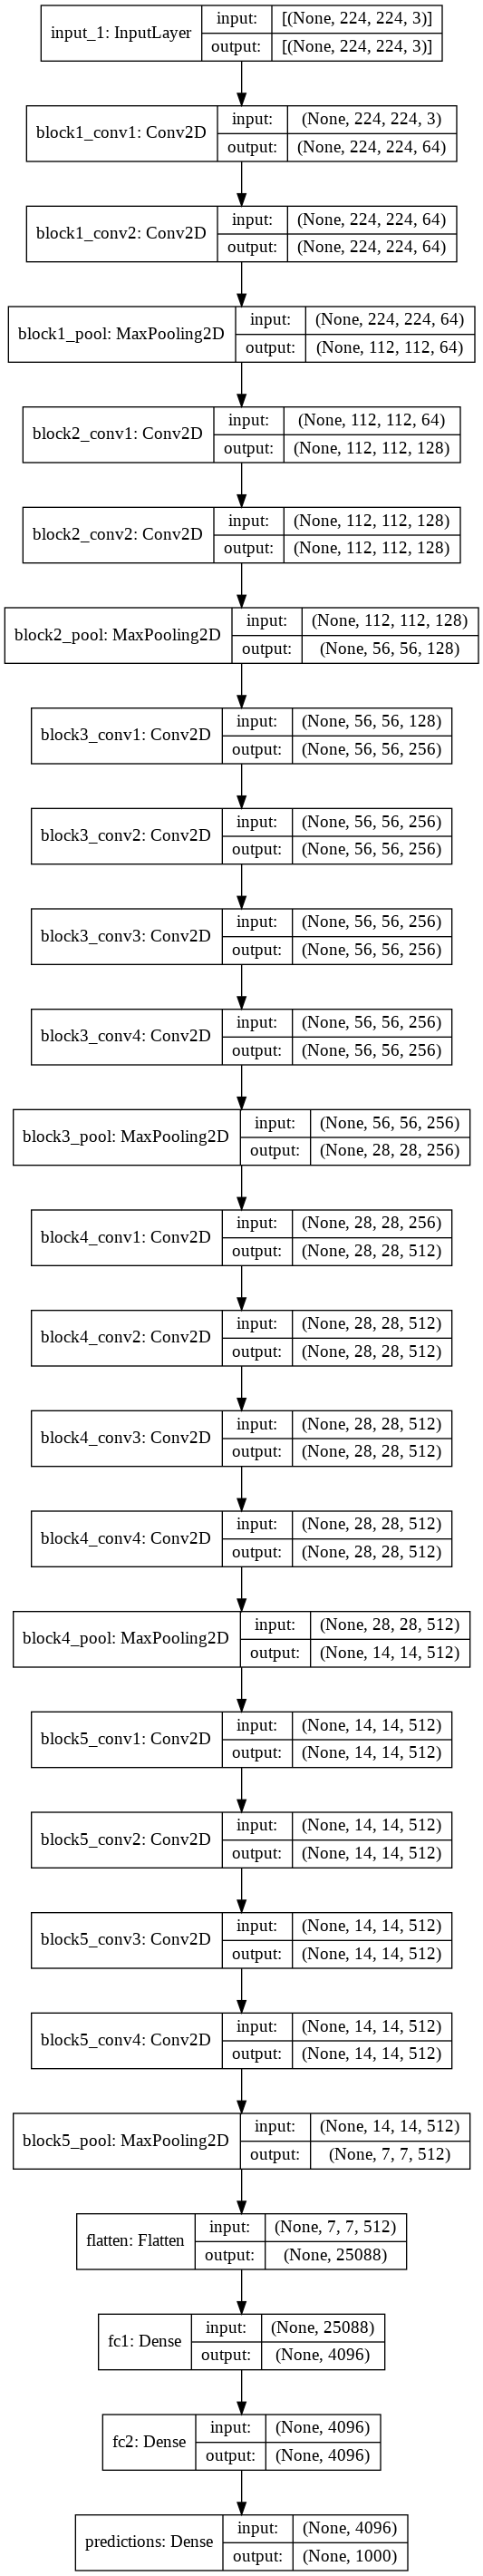

In [9]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [10]:
# list of layers where we may want to apply rsi-grad-cam
# (listed from input to output)

layer_names = ['input_1', 'block1_pool', 'block2_pool', 'block3_pool', 'block4_pool', 'block5_pool']

In [11]:
IMAGE_SIZE_1, IMAGE_SIZE_2, IMAGE_SIZE_3 = model.input.shape[1:]
INPUT_SHAPE = (IMAGE_SIZE_1, IMAGE_SIZE_2, IMAGE_SIZE_3)
IMAG_SIZE = (IMAGE_SIZE_1, IMAGE_SIZE_2)
print(INPUT_SHAPE, IMAG_SIZE)

(224, 224, 3) (224, 224)


# **Display heatmaps**

In [12]:
# baseline is black image
baseline = tf.zeros(shape=INPUT_SHAPE)
baseline = imagenet_utils.preprocess_input(baseline) # for consistency to be used with VGG19

In [13]:
def display_heatmaps(orig_image,layerName,top_pred=0):

    '''
    inputs are:
    - orig_image = the original image
    - layerName = name of the layer used to generate the heatmap
    - top_pred = which class we what to locate starting a the top predicted,
      i.e., 0 = class with the top (highest) score, 1 = second top, etc.
    '''

    print('layerName =',layerName)
    print()

    orig_bgr = cv2.imread(orig_image) # cv2 loads in BGR format
    orig_rgb = cv2.cvtColor(orig_bgr, cv2.COLOR_BGR2RGB) # transform to RGB

    # load the input image from disk (in Keras/TensorFlow format) 
    # and preprocess it
    image = load_img(orig_image, target_size=IMAG_SIZE) # RGB
    image = img_to_array(image)

    image = np.expand_dims(image, axis=0) # make the image a 1-element batch

    image = imagenet_utils.preprocess_input(image) # default mode: caffe
    # caffe: will convert the images from RGB to BGR, 
    # then will zero-center each color channel with respect 
    # to the ImageNet dataset, without scaling.

    # use the network to make predictions on the input imag and find
    # the class label index with the largest corresponding probability
    preds = model.predict(image)
    
    # select the index of the class we want to locate in the image
    i = np.argsort(preds[0])[-1-top_pred]

    # decode the ImageNet predictions to obtain the human-readable label
    decoded = imagenet_utils.decode_predictions(preds, top=30)

    # uncomment next lines if you want to see the top predictions
    '''
    for j in range(len(decoded[0])):
        print(j, decoded[0][j])
    '''

    (imagenetID, label, prob) = decoded[0][top_pred]
    label = "{}: {:.4f}%".format(label, prob * 100)
    print('image index =', i)
    print()
    print("[INFO] {}".format(label))

    # instantiate rsi-grad-cam
    rsi_gradcam = RSI_GradCAM(model, i, layerName=layerName, baseline=baseline)

    # produce heatmaps
    heatmap_rsi_gradcam = rsi_gradcam.compute_heatmap(image)

    # resize the resulting heatmaps to the original input image dimensions
    # and then overlay heatmap on top of the image
    heatmap_rsi_gradcam = cv2.resize(heatmap_rsi_gradcam, (orig_rgb.shape[1], orig_rgb.shape[0]))
    (heatmap_rsi_gradcam, output_rsi_gradcam) = rsi_gradcam.overlay_heatmap(heatmap_rsi_gradcam, orig_rgb, alpha=0.5)

    # display the original image and resulting heatmap and output image
    output_rsi_gradcam = np.vstack([orig_rgb, heatmap_rsi_gradcam, output_rsi_gradcam])
    output_rsi_gradcam = imutils.resize(output_rsi_gradcam, height=700)

    plt.rcParams.update({'font.size':15})
    plt.figure(figsize=(10,10))

    plt.imshow(output_rsi_gradcam)
    plt.title('RSI-Grad-CAM')
    plt.axis('off')

pass

In [14]:
orig_image = root + 'images/beagle.jpg'

layerName = block5_pool

image index = 162

[INFO] beagle: 64.8098%


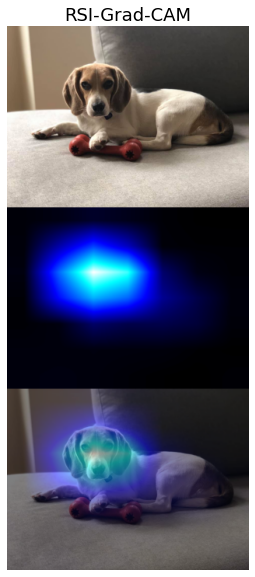

In [15]:
display_heatmaps(orig_image,layer_names[-1])

layerName = block4_pool

image index = 162

[INFO] beagle: 64.8098%


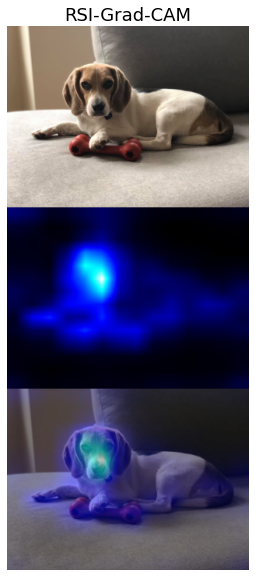

In [16]:
display_heatmaps(orig_image,layer_names[-2])

In [17]:
orig_image = root + 'images/space_shuttle.jpg'

layerName = block5_pool

image index = 812

[INFO] space_shuttle: 100.0000%


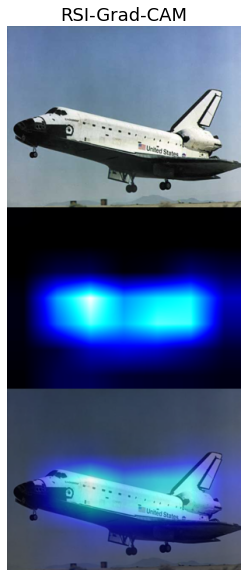

In [18]:
display_heatmaps(orig_image,layer_names[-1])

layerName = block4_pool

image index = 812

[INFO] space_shuttle: 100.0000%


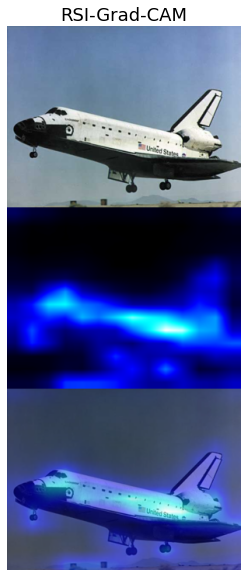

In [19]:
display_heatmaps(orig_image,layer_names[-2])

In [20]:
orig_image = root + 'images/soccer_ball.jpg'

layerName = block5_pool

image index = 805

[INFO] soccer_ball: 85.5707%


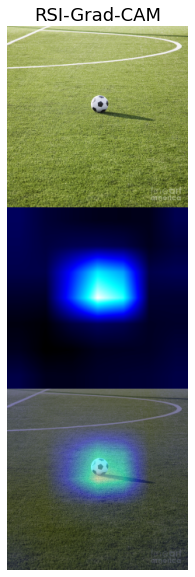

In [21]:
display_heatmaps(orig_image,layer_names[-1])

layerName = block4_pool

image index = 805

[INFO] soccer_ball: 85.5707%


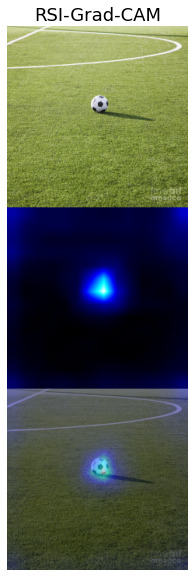

In [22]:
display_heatmaps(orig_image,layer_names[-2])

In [23]:
orig_image = root + 'images/dog-and-cat.jpg'

layerName = block5_pool

image index = 235

[INFO] German_shepherd: 67.7826%


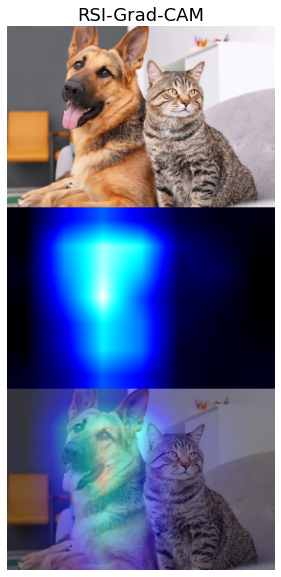

In [24]:
display_heatmaps(orig_image,layer_names[-1])

layerName = block5_pool

image index = 281

[INFO] tabby: 0.2248%


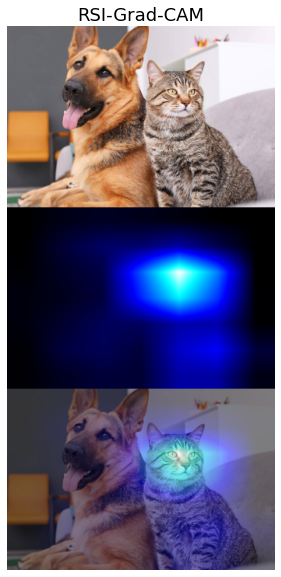

In [25]:
display_heatmaps(orig_image,layer_names[-1],top_pred=19)